In [6]:
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [7]:
train_data = pd.read_csv('cleared_train_data.csv',encoding='utf-8',sep=',')
test_data = pd.read_csv('cleared_test_data.csv', encoding='utf-8', sep=',')

In [8]:
train_data.drop('PassengerId', axis=1,inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)

In [9]:
class_weight = compute_class_weight('balanced',classes = train_data.Survived.unique(), y = train_data.Survived)
class_weight_dict = {label: weight for label, weight in zip(train_data.Survived.unique(), class_weight)}

In [10]:
decision_tree = DecisionTreeClassifier(criterion='gini',max_depth=5, random_state=23, class_weight=class_weight_dict)

In [11]:
y_train = train_data.pop('Survived')

In [12]:
decision_tree.fit(train_data, y_train)

DecisionTreeClassifier(class_weight={0: 0.8202764976958525,
                                     1: 1.2805755395683454},
                       max_depth=5, random_state=23)

Признак Pclass: 0.08923933020705561
Признак Sex: 0.5108981750867875
Признак Age: 0.12120174743243878
Признак SibSp: 0.05284902786715932
Признак Parch: 0.010042792792644457
Признак Ticket: 0.09251556625294542
Признак Fare: 0.09940670536839677
Признак Cabin: 0.02384665499257227
Признак Embarked: 0.0


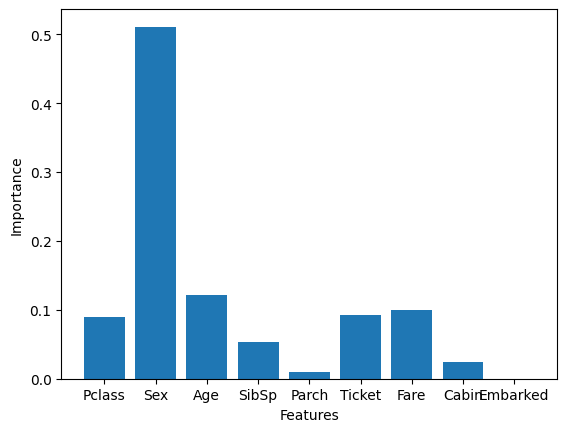

In [13]:
feature_importances = decision_tree.feature_importances_
for feature, importance in zip(train_data.columns, feature_importances):
    print(f'Признак {feature}: {importance}')

plt.bar(train_data.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Самой важной фичей является пол. Пояснять почему не вижу смысла
Дальше идет возраст и плата за проезд.
Номер кабины практически не влияет на выживаемость: всего 0.02 процента.
Точка высадки вообще не оказывает влияния на выживаемость - 0%

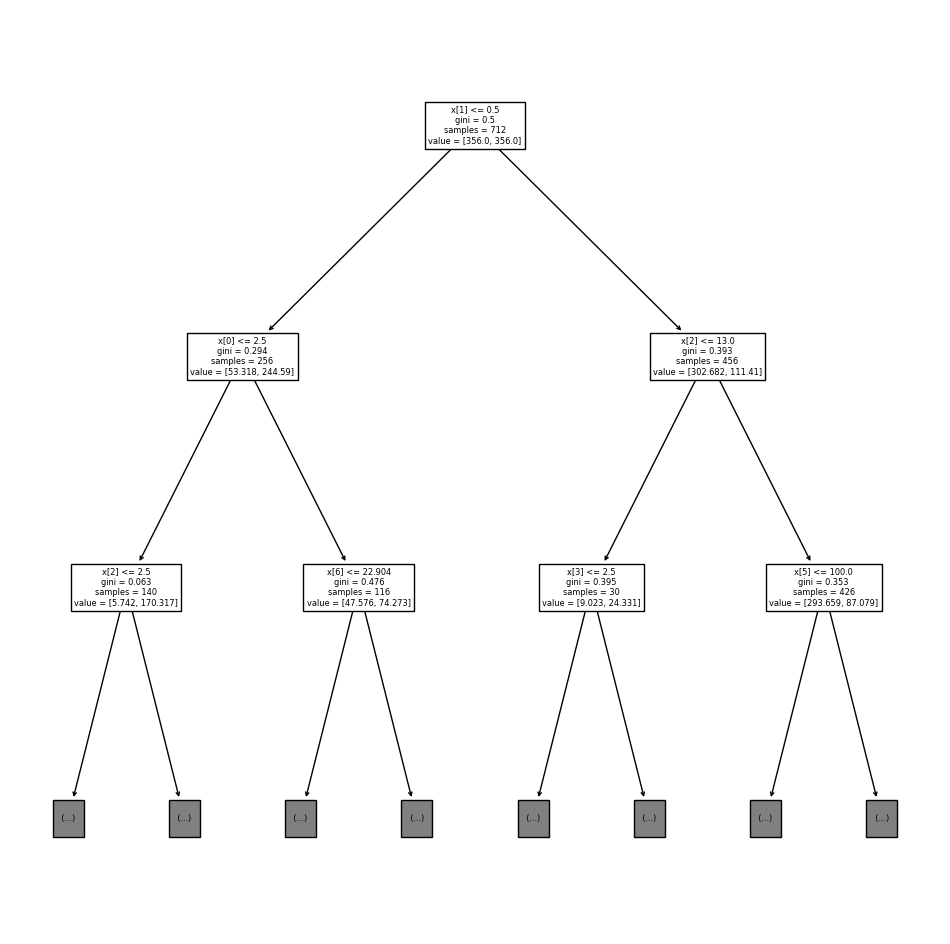

In [14]:
plt.figure(figsize=(12,12))
plot_tree(decision_tree=decision_tree, max_depth=2)
plt.show()

In [15]:
y_test = test_data.pop('Survived')

In [16]:
decision_tree.score(test_data, y_test)

0.7932960893854749

In [17]:
roc_auc_score(y_test, decision_tree.predict(test_data))

0.7940896739130434

In [18]:
f1_score(y_test, decision_tree.predict(test_data))

0.7338129496402876

К перекрестная проверка

In [108]:
cv_score = cross_val_score(decision_tree, test_data, y_test, cv=5, scoring='roc_auc', n_jobs=-1)

In [109]:
cv_score.max() # roc_auc

0.8193979933110367

Поиск по сетке

In [19]:
grid_params={
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best'],
    'max_depth' : [None, 3,4,5,6,7,8,9,10,11,12],
    'random_state' : [23,24,25,26,27,28],
    'class_weight' : [class_weight_dict]
}
decision_tree = DecisionTreeClassifier()
grid = GridSearchCV(decision_tree, grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(train_data, y_train)
best_params = grid.best_params_
best_score = grid.best_score_
best_estimator = grid.best_estimator_

In [20]:
best_params

{'class_weight': {1: 1.2805755395683454, 0: 0.8202764976958525},
 'criterion': 'entropy',
 'max_depth': 5,
 'random_state': 28,
 'splitter': 'best'}

In [21]:
best_score

0.8523824017468765

In [22]:
best_estimator.score(test_data, y_test)

0.7653631284916201

In [23]:
roc_auc_score(y_test, best_estimator.predict(test_data))

0.7550271739130434

In [24]:
cv_score = cross_val_score(best_estimator, test_data, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
cv_score.mean()

0.7951783723522855

In [25]:
best_estimator.score(test_data, y_test)

0.7653631284916201

Случайный лес c поиском по сетке

In [26]:
grid_params ={
    'n_estimators' : [50,60,70,80,90,100],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [None, 3,4,5,6,7,8,9,10,11,12],
    'random_state' : [23,24,25,26,27,28],
    'class_weight' : [class_weight_dict],
    'n_jobs' : [-1],
}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, grid_params, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(train_data, y_train)
best_estimator = grid.best_estimator_
best_score = grid.best_score_
best_params = grid.best_params_

In [27]:
best_score

0.8819896062237682

In [28]:
best_params

{'class_weight': {1: 1.2805755395683454, 0: 0.8202764976958525},
 'criterion': 'entropy',
 'max_depth': 10,
 'n_estimators': 60,
 'n_jobs': -1,
 'random_state': 25}

In [29]:
cv_score = cross_val_score(best_estimator, test_data, y_test, cv=5, n_jobs=-1, scoring='roc_auc')
cv_score.mean()

0.8110646599777034

In [ ]:
best_estimator.score(test_data, y_test)

Bagging с поиском по сетке

In [121]:
decision_tree = DecisionTreeClassifier(class_weight=class_weight_dict)
grid_params ={
    'n_estimators' : [50,60,70,80,90,100],
    'random_state' : [23,24,25,26,27,28],
    'estimator': [decision_tree]
}
bagging = BaggingClassifier(n_jobs=-1)
grid = GridSearchCV(bagging, grid_params, cv=5, n_jobs=-1, scoring='roc_auc')
grid.fit(train_data, y_train)
best_score = grid.best_score_
best_params = grid.best_params_
best_estimator = grid.best_estimator_

In [122]:
best_score

0.8710011082875958

In [123]:
best_params

{'estimator': DecisionTreeClassifier(class_weight={0: 0.8202764976958525,
                                      1: 1.2805755395683454}),
 'n_estimators': 70,
 'random_state': 28}

In [125]:
cv_score = cross_val_score(best_estimator, test_data, y_test, scoring='roc_auc')
cv_score.max()

0.8846153846153846

Boosting с поиском по сетке

In [129]:
grid_params ={
    'n_estimators' : [50,60,70,80,90,100],
    'random_state' : [23,24,25,26,27,28],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [i/1000 for i in range(1,100)]
}
decision_tree = DecisionTreeClassifier(class_weight=class_weight_dict)
boosting = AdaBoostClassifier(decision_tree)
grid = GridSearchCV(boosting, grid_params, scoring='roc_auc', n_jobs=-1, cv=5)
grid.fit(train_data, y_train)
best_estimator = grid.best_estimator_
best_score = grid.best_score_
best_params = grid.best_params_

In [130]:
best_score

0.828208371086278

In [131]:
best_params

{'algorithm': 'SAMME.R',
 'learning_rate': 0.024,
 'n_estimators': 100,
 'random_state': 23}

In [132]:
cv_score = cross_val_score(best_estimator, test_data, y_test, scoring='roc_auc', n_jobs=-1)
cv_score.max()

0.7859531772575251

In [137]:
svm = SVC()
grid_params ={
    'C' : [0.9,0.95,1.0],
    'random_state' : [23,24,25,26,27,28],
    'kernel' : ['linear', 'poly', 'sigmoid', 'rbf'],
    'class_weight' : [class_weight_dict]
}
grid = GridSearchCV(svm, grid_params, scoring='roc_auc', n_jobs=-1, cv=5)
grid.fit(train_data, y_train)
best_estimator = grid.best_estimator_
best_score = grid.best_score_
best_params = grid.best_params_

In [138]:
best_score

0.8496063365931048

In [139]:
best_params

{'C': 1.0,
 'class_weight': {1: 1.2805755395683454, 0: 0.8202764976958525},
 'kernel': 'linear',
 'random_state': 23}

In [140]:
cv_score = cross_val_score(best_estimator, test_data, y_test, n_jobs=-1, scoring='roc_auc')
cv_score.max()

0.8896321070234113

В ходе работы были использованы ансамблевые методы(где estimator'ом была модель дерево решений) для решения задач классификации: Boosting, Bagging, RandomForest; методы обучения с учителем: Дерево решений и метод опорных векторов. Для оптимизации параметров использовался метод поиск по сетке. Были подсчитаны такие метрики как: f1-score, roc_auc и accuracy. Всвязи с тем, что было известно о дисбалансе классов я использовал внутренние инструменты scikit-learn: compute_class_weight; для борьбы с дисбалансом классов. Были построены график важности фич, где самой важной оказался - пол(такой же результат был получен при построении матрицы корреляции) и график самого дерева с ограничением глубины = 2 для лучшего отображения результата. Самым точным алгоритмом для предсказания целевой метки класса: Survived; оказался метод опорных векторов, где использовался поиск по сетки для оптимизации параметров. Что удивительно, метод показал одним из наилучших параметров kernel = linear, что свидетельствует о том, что данные линейно разделимы. Худше всего себя показал ансамблевый метод Boosting, где в качестве решателя использовалась модель Дерева решений, что удивительно, т.к. алгоритм обучался с большим набором гиперпаратметров и обучение заняло 22 минуты и 30 секунд. 